# Hierarchical pendulum SBI, using a csv of (theta, x)

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble.

In [1]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
#from src.scripts import utils
import numpyro

In [2]:
import deepbench
from deepbench.physics_object import Pendulum
print(deepbench.__version__)


0.2.01


In [4]:
from sbi import utils, inference, analysis
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.inference.base import infer
import torch

## Prepare dataframe that associates (theta, x)
Here, I run a quick simulation that grid-searches all the theta values.

In [22]:
def save_thetas_and_xs_single(thetas_in, rng_key):
    # except length will have 8 elements as will theta
    length, theta, μ_a_g, σ_a_g = thetas_in

    a_g = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01))
    #rng_key = jax.random.PRNGKey(1)  # You can use any valid random key
    #a_g_1 = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01), rng_key = rng_key)

    #a_g = [a_g_0, a_g_1]
    #print('a_g', a_g)
    
    
    pendulum = Pendulum(
                pendulum_arm_length=float(length),
                starting_angle_radians=float(theta),
                acceleration_due_to_gravity=float(a_g),
                noise_std_percent={
                    "pendulum_arm_length": 0.0,
                    "starting_angle_radians": 0.1,
                    "acceleration_due_to_gravity": 0.0,
                },
            )
    x = pendulum.create_object(0.75, noiseless=False)
    del pendulum
    return a_g, x
    

In [23]:
from numpyro.util import enable_x64

enable_x64()

import jax.numpy as jnp
import jax
rng_key = jax.random.PRNGKey(0)
print(rng_key)

[0 0]


In [15]:
# set priors for all of these things

In [24]:
# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 100
xs = np.zeros((2*length_df, 3))
#labels = np.zeros((2*length_df, 2))
#error = []
#y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    
    
    length = abs(rs.normal(loc=5, scale=2))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500))
    #length, theta, μ_a_g, σ_a_g = thetas_in
    μ_a_g = abs(rs.normal(loc=10, scale=2))
    σ_a_g = abs(rs.normal(loc=1, scale=0.5))

    thetas_in = [length, theta, μ_a_g, σ_a_g]

    a_g, x = save_thetas_and_xs_single(thetas_in, rs)
        
    
    xs[r,:] = [length, theta, a_g, μ_a_g, σ_a_g, x]
    #labels[r,:] = [0, r]
    
    
    

    


AssertionError: 

Okay define the priors as uniform distributions.

In [6]:
num_dim = 3

# there are three priors for the non-hierarchical run of SBI:
low_bounds = torch.tensor([1, np.pi/500, 1])
high_bounds = torch.tensor([10, 3*np.pi/200, 20])
# length, theta, μ_a_g, σ_a_g, σ = thetas

prior = utils.BoxUniform(low = low_bounds, high = high_bounds)
print(prior.sample())

# there are 
low_bounds = torch.tensor([1, np.pi/500, 1, 0.1])
high_bounds = torch.tensor([10, 3*np.pi/200, 20, 5])
# length, theta, μ_a_g, σ_a_g, σ = thetas

prior_hierarchical = utils.BoxUniform(low = low_bounds, high = high_bounds)
print(prior.sample())

tensor([1.0209, 0.0110, 3.8003])
tensor([1.6288, 0.0146, 3.9883])


In [7]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    length, theta, a_g = thetas
    #print('heres what were inputting', thetas, a_g)
    #length_percent_error_all, theta_percent_error_all, a_g_percent_error_all = \
    #    percent_errors
    pendulum = Pendulum(
        pendulum_arm_length=float(length),
        starting_angle_radians=float(theta),
        acceleration_due_to_gravity=float(a_g),
        noise_std_percent={
            "pendulum_arm_length": 0.0,
            "starting_angle_radians": 0.1,
            "acceleration_due_to_gravity": 0.0,
        },
    )
    output = np.array(pendulum.create_object(np.linspace(0,2,100), noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output



def linear_gaussian(theta):
    output = theta + 1.0 + torch.randn_like(theta) * 0.1
    return output

## Hierarchical SBI
Okay so normally the simulator functions within SBI to return one observation for every time you sample from the prior. So how do we build this within a hierarchical structure? Also how do we preserve the groupings?
1. Do we need to simulate a set of observations (ie multiple observations)
2. Do we need a trickle down effect where you draw from population level parameter and then this determines which group you fall into, so it's still one observation all the way through?

A simulator simply takes parameters (thetas) and outputs data (x). So in the hierarchical pendulum example, we would be giving it length, theta, μ_a_g, and σ_a_g. It would take these and have a deterministic way to get to a_g, maybe from randomly drawing from the μ_a_g and σ_a_g distribution?

In the first case, we would draw two a_g values randomly and then for each of these we would have four pendulums.

In [10]:
# is it actually possible to set up a hierarchical model in this way?
# can we actually that the pendulums are actually on two different planets?
# how do you set up a simulator so that it knows about placing pendulums into groups?

import jax


# okay so you need to pass it parameters on all levels
# each of these parameters will have a prior
def hierarchical_simulator_set(thetas):
    # except length will have 8 elements as will theta
    length0, length1, length2, length3, theta0, theta1, theta2, theta3, μ_a_g, σ_a_g = thetas

    length = [length0, length1, length2, length3]
    theta = [theta0, theta1, theta2, theta3]
    # draw two a_g values
    rng_key = jax.random.PRNGKey(0)  # You can use any valid random key
    #a_g = np.zeros(2)
    #print(μ_a_g, σ_a_g)
    #print(float(μ_a_g), float(σ_a_g))
    a_g_0 = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01), rng_key = rng_key)
    rng_key = jax.random.PRNGKey(1)  # You can use any valid random key
    a_g_1 = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(float(μ_a_g), float(σ_a_g), low = 0.01), rng_key = rng_key)

    a_g = [a_g_0, a_g_1]
    #print('a_g', a_g)
    
    output = []#np.zeros((2,4))
    for j in range(2):
        for i in range(4):
            #print('input params are', float(length[i]), float(theta[i]), float(a_g[j]))
            pendulum = Pendulum(
                pendulum_arm_length=float(length[i]),
                starting_angle_radians=float(theta[i]),
                acceleration_due_to_gravity=float(a_g[j]),
                noise_std_percent={
                    "pendulum_arm_length": 0.0,
                    "starting_angle_radians": 0.1,
                    "acceleration_due_to_gravity": 0.0,
                },
            )
            #np.linspace(0,2,100)
            #print('output', np.array(pendulum.create_object(0.75, noiseless=False)))
            output.append(pendulum.create_object(0.75, noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output

def hierarchical_simulator_trickle_down(thetas):
    # just plop the pendulum within here

    #μ_a_g
    #σ_a_g
    #a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g, low = 0.01))
    # ^ I'm not sure how to to draw one parameter nested from another
    # in SBI you don't make a sampling distribution, you set an exact equality
    # unless you're introducing noise
    # and then there's some element of random sampling

    length, theta, μ_a_g, σ_a_g = thetas #, σ
    
    '''
    μ_a_g = numpyro.sample("μ_a_g", dist.TruncatedNormal(12.5, 2, low = 0.01))
    # scale parameters should be log uniform so that they don't go negative 
    # and so that they're not uniform
    # 1 / x in linear space
    σ_a_g = numpyro.sample("σ_a_g", dist.TruncatedNormal(2, 0.5, low = 0.01))
    '''
    n_planets = 2
    n_pendulums = 8

    rng_key = jax.random.PRNGKey(0)  # You can use any valid random key

    ## plates are a numpyro primitive or context manager for handing conditionally independence
    ## for instance, we wish to model a_g for each planet independently
    with numpyro.plate("planet_i", n_planets):
        #a_g = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(μ_a_g, σ_a_g, low = 0.01))
        a_g = numpyro.sample("a_g", numpyro.distributions.TruncatedNormal(μ_a_g, σ_a_g, low = 0.01), rng_key = rng_key)
        
        
        print(a_g)
        #a_g = numpyro.sample("a_g", utils.MultivariateNormal(μ_a_g, σ_a_g))
        #a_g = numpyro.sample("a_g", torch.normal(μ_a_g, σ_a_g))
        
    '''
    ## we also wish to model L and theta for each pendulum independently
    ## here we draw from an uniform distribution
    with numpyro.plate("pend_i", n_pendulums):
        L = 5#numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0.01))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100,jnp.pi/500, low = 0.00001))
    '''
    ## σ is the error on the position measurement for each moment in time
    ## we also model this
    ## eventually, we should also model the error on each parameter independently?
    ## draw from an exponential distribution parameterized by a rate parameter
    ## the mean of an exponential distribution is 1/r where r is the rate parameter
    ## exponential distributions are never negative. This is good for error.
    #σ = numpyro.sample("σ", dist.Exponential(exponential))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    
    ## the moments in time are not independent, so we do not place the following in a plate
    ## instead, the brackets segment the model by pendulum and by planet,
    ## telling us how to conduct the inference
    #modelx = L * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L) * times))
    
    
    #print('heres what were inputting', thetas, a_g)
    #length_percent_error_all, theta_percent_error_all, a_g_percent_error_all = \
    #    percent_errors
    pendulum = Pendulum(
        pendulum_arm_length=float(length),
        starting_angle_radians=float(theta),
        acceleration_due_to_gravity=float(a_g),
        noise_std_percent={
            "pendulum_arm_length": 0.0,
            "starting_angle_radians": 0.1,
            "acceleration_due_to_gravity": 0.0,
        },
    )
    output = np.array(pendulum.create_object(np.linspace(0,2,100), noiseless=False))
    #torch.tensor(pendulum.create_object(0.75, noiseless=False))
    
    return output

In [11]:
posterior = infer(simulator, prior, "SNPE", num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 111 epochs.

[ 0.07921495  0.07027974  0.06662527  0.07621434  0.07077415  0.06269746
  0.07880024  0.08454877  0.08227284  0.06721483  0.07129516  0.08279749
  0.08357902  0.07256901  0.06666398  0.0747355   0.0689241   0.07429485
  0.07645687  0.07943256  0.07584037  0.0678135   0.06349518  0.07712545
  0.07649205  0.05763281  0.06255803  0.06727438  0.06185245  0.0733255
  0.06081647  0.05823604  0.0553191   0.05206561  0.04906433  0.0475478
  0.04512467  0.05528936  0.04578827  0.04806015  0.0392363   0.04950445
  0.04630451  0.03652557  0.03951714  0.04226617  0.03509362  0.03521216
  0.03247565  0.03080702  0.03167137  0.029727    0.02335592  0.0241317
  0.02190575  0.01529586  0.01744404  0.01863988  0.01534716  0.01140445
  0.01125664  0.00874129  0.0071058   0.00582418  0.00353929  0.00116501
 -0.00054388 -0.00228298 -0.00467677 -0.00688156 -0.00606302 -0.00961926
 -0.01261416 -0.01451806 -0.01354774 -0.01782058 -0.01518909 -0.02219019
 -0.01822729 -0.01864312 -0.028804   -0.02699951 -0.02

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

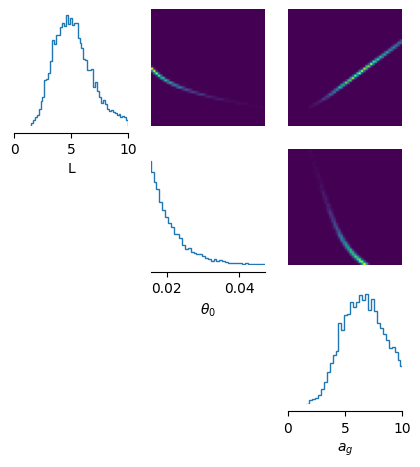

In [12]:
#x_o_1 = simulator([5, np.pi/100, 5])
x_o_1 = simulator([5, np.pi/200, 7])
print(x_o_1)
posterior_samples_1 = posterior.sample((10000,), x=x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, 
    labels = ['L',r'$\theta_0$','$a_g$'],
    limits = [[0,10],[np.pi/200,3*np.pi/200],[0,10]],
    truths = [5, np.pi/100, 5],
    figsize=(5, 5)
)


In [13]:
#hierarchical_simulator_set
low_bounds = torch.tensor([1,1,1,1,
                           np.pi/500,np.pi/500,np.pi/500,np.pi/500,
                           1, 0.1])
high_bounds = torch.tensor([10,10,10,10,
                           3*np.pi/200,3*np.pi/200,3*np.pi/200,3*np.pi/200,
                           20, 5])
# length, theta, μ_a_g, σ_a_g, σ = thetas

prior_hierarchical_set = utils.BoxUniform(low = low_bounds, high = high_bounds)
print(prior_hierarchical_set.sample())

tensor([1.9549e+00, 7.1132e+00, 6.9173e+00, 6.6374e+00, 4.3555e-02, 2.1143e-02,
        1.6676e-02, 8.3687e-03, 1.6616e+01, 7.3116e-01])


In [14]:
# test the simulator
params = prior_hierarchical_set.sample()
print('params', params, 'x', hierarchical_simulator_set(params))

params tensor([2.2631, 1.6139, 1.5512, 8.0012, 0.0224, 0.0194, 0.0107, 0.0309, 4.8149,
        4.0468]) x [0.024075612848885646, 0.009453163222649543, 0.00443071625492635, 0.1856442519930846, 0.03825960489734425, 0.02350770473750912, 0.011666416555408508, 0.27374498138068126]


In [15]:
posterior = infer(hierarchical_simulator_set, prior_hierarchical_set, "SNPE", num_simulations=100)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 292 epochs.

true params tensor([ 3.7647,  8.5289,  9.9282,  7.7267,  0.0238,  0.0283,  0.0315,  0.0259,
        19.0272,  0.4683])
observed xs [-0.010889280721812136, 0.09395263336620809, 0.16300389344264327, 0.07095483423229111, -0.00850478661515785, 0.11003378645481518, 0.21797733160093158, 0.07930307461827268]


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

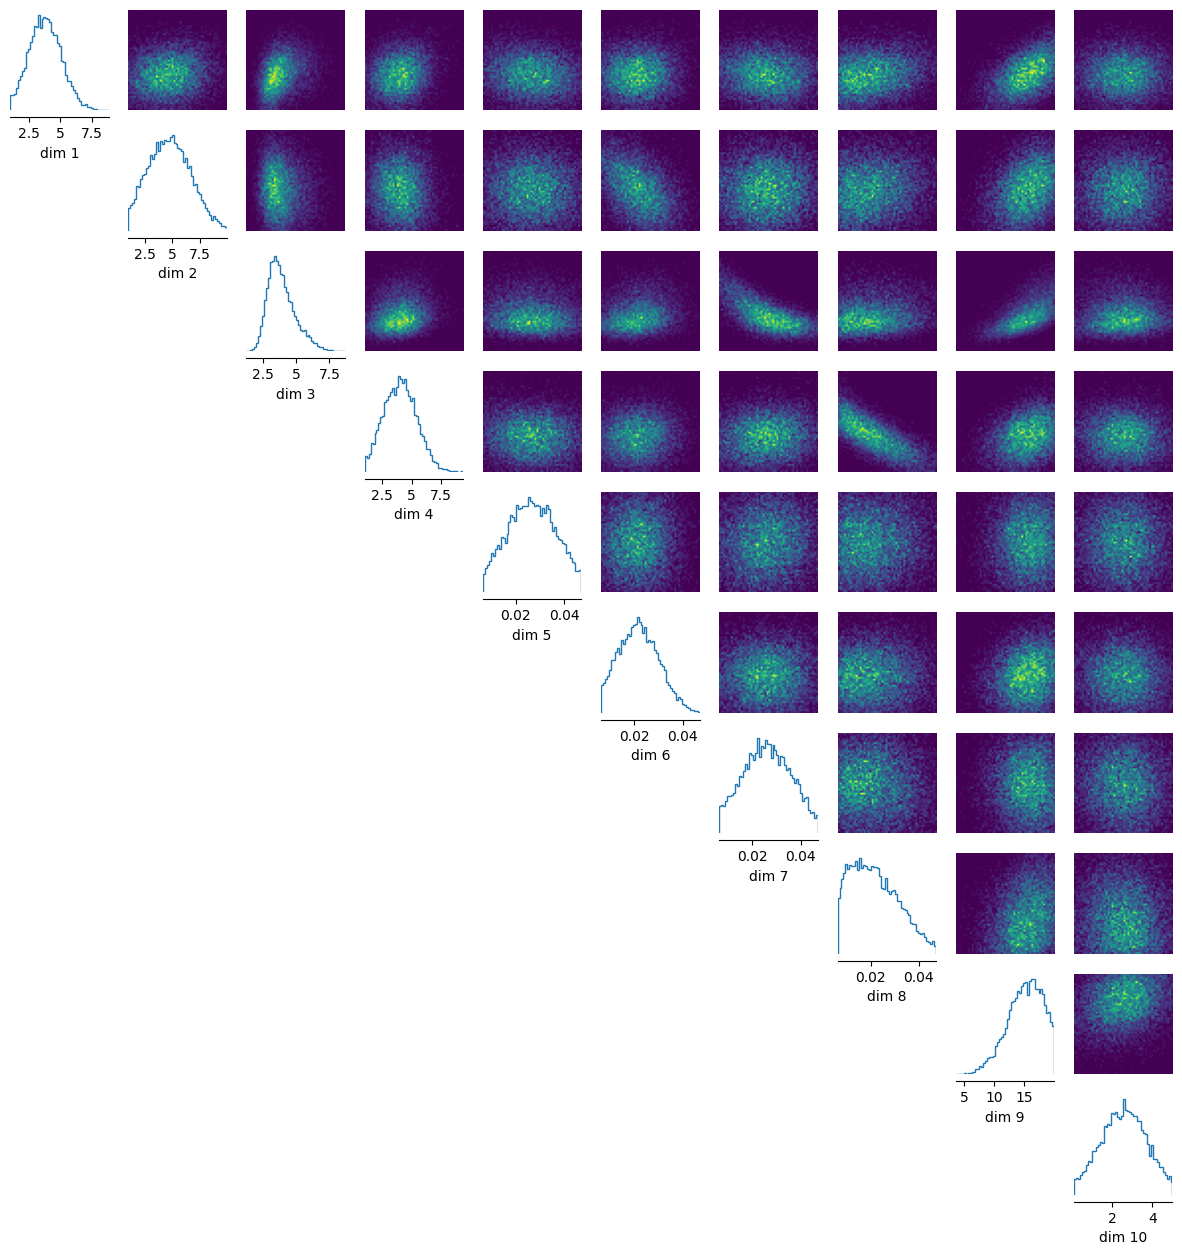

In [16]:
params = prior_hierarchical_set.sample()
print('true params', params)
x_o_1 = hierarchical_simulator_set(params)
print('observed xs', x_o_1)
# give it all the same position
xs = [0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018]
posterior_samples_1 = posterior.sample((10000,), x=xs)#x_o_1)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, 
    #labels = ['L',r'$\theta_0$','$a_g$'],
    #limits = [[0,10],[np.pi/200,3*np.pi/200],[0,10]],
    truths = params,
    figsize=(15, 15)
)